Taking zips and extracting the data to the extracted folder

In [2]:
import zipfile
import os

for file in os.listdir('met_eireann_data/zips'):
    if file.endswith('.zip'):
        path_to_zip_file = os.path.join('met_eireann_data/zips', file)
        directory_to_extract_to = os.path.join('met_eireann_data/extracted', file[:-4])  # Remove .zip extension
        if not os.path.exists(directory_to_extract_to):
            os.makedirs(directory_to_extract_to)
        
            with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
                zip_ref.extractall(directory_to_extract_to)

Pipeline to clean data from current format to each row including the station name and all of available weather data

In [13]:
import pandas as pd
dfs = []
for folder in os.listdir('met_eireann_data/extracted'):
    if os.path.isdir(os.path.join('met_eireann_data/extracted', folder)):
        for file in os.listdir(os.path.join('met_eireann_data/extracted', folder)):
            if file.endswith('.csv'):
                skiprows = 0
                with open(f'met_eireann_data/extracted/{folder}/{file}', 'r') as f:
                    for line in f:
                        if line.startswith('Station Name'):
                            station_name = line.split(':')[1].strip()
                        elif line.startswith('Latitude'):
                            Latitude = line.split(',')[0].strip()
                            Longitude = line.split(',')[1].strip()
                        elif line.startswith('Station Height'):
                            Station_Height = line.split(':')[1].strip()
                        elif line.split(',')[0] == 'date':
                            break
                        elif line.split(',')[0] == 'date':
                            break
                        skiprows += 1
                df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)
                dfs.append((df, station_name, Latitude, Longitude, Station_Height, file))

                # with open(f'met_eireann_data/extracted/{folder}/{file[:-4]}.txt', 'w') as f:
                #     with open(f'met_eireann_data/extracted/{folder}/{file}', 'r') as f2:
                #         for line in f2:
                            
                print(file, station_name, Latitude, Longitude, Station_Height, df.shape)

/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1219256751.py:22: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)


hly2075.csv FINNER Latitude:54.494 Longitude: -8.243 33 M (239443, 15)
hly1575.csv MALIN HEAD Latitude:55.372 Longitude: -7.339 20 M (16828, 21)


/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1219256751.py:22: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)


hly275.csv MACE HEAD Latitude:53.326 Longitude: -9.901 21 M (193320, 15)


/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1219256751.py:22: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)


hly875.csv MULLINGAR Latitude:53.537 Longitude: -7.362 101 M (454224, 15)


/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1219256751.py:22: DtypeWarning: Columns (2,4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)


hly1175.csv NEWPORT Latitude:53.924 Longitude: -9.573 22 M (181176, 15)


/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1219256751.py:22: DtypeWarning: Columns (2,4,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)


hly175.csv PHOENIX PARK Latitude:53.364 Longitude: -6.350 48 M (193248, 11)


/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1219256751.py:22: DtypeWarning: Columns (6,12,14,15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)


hly518.csv SHANNON AIRPORT Latitude:52.690 Longitude: -8.918 15 M (701280, 21)
hly1275.csv MARKREE Latitude:54.175 Longitude: -8.456 34 M (178152, 11)


/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1219256751.py:22: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)


hly1875.csv ATHENRY Latitude:53.289 Longitude: -8.786 40 M (136008, 15)


/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1219256751.py:22: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)


hly2275.csv VALENTIA OBSERVATORY Latitude:51.938 Longitude: -10.241 24 M (707112, 21)


/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1219256751.py:22: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)


hly1775.csv JOHNSTOWN CASTLE 2 Latitude:52.298 Longitude: -6.497 62 M (193344, 15)


/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1219256751.py:22: DtypeWarning: Columns (2,4,6,7,8,9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)


hly1475.csv GURTEEN Latitude:53.035 Longitude: -8.009 75 M (154224, 15)


/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1219256751.py:22: DtypeWarning: Columns (2,4,6,7,8,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)


hly775.csv SHERKIN ISLAND Latitude:51.476 Longitude: -9.428 21 M (187056, 15)


/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1219256751.py:22: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)


hly1075.csv ROCHES POINT Latitude:51.793 Longitude: -8.244 40 M (592127, 15)


In [ ]:
# Process date column to datetime object and filter to only include data from 2014 onwards
# Add station name at the start and save station metadata in a separate csv file.
# Convert rain, temp, wetb, dewpt, vappr, rhum, msl, wdsp, wddir, sun, vis, clht, clamt to float values if they are columns in the dataframe
# If there are any non float values in these columns (e.g ' ' or '---') convert them to NaN
# Save cleaned data to new csv files in a new folder titled cleaned and file name as station_name.csv


from datetime import datetime


for df_list in dfs:
    df, station_name, Latitude, Longitude, Station_Height, file = df_list

    # Process date column to datetime object
    df['date'] = pd.to_datetime(df['date'], format='mixed')
    df = df[df['date'] >= datetime(2014, 1, 1)]

    # clean columns and convert to numeric values 
    columns_to_convert = ['rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl', 'wdsp', 'wddir', 'sun', 'vis', 'clht', 'clamt']
    for col in columns_to_convert:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    if not os.path.exists('met_eireann_data/cleaned'):
        os.makedirs('met_eireann_data/cleaned')
    
    # write additional metadata to a separate txt file with the same name as the csv file
    with open(f'met_eireann_data/cleaned/{station_name}_metadata.txt', 'w') as f:
        f.write(f'Station Name: {station_name}\n')
        f.write(f'Latitude: {Latitude}\n')
        f.write(f'Longitude: {Longitude}\n')
        f.write(f'Station Height: {Station_Height}\n')

    df.to_csv(f'met_eireann_data/cleaned/{station_name}.csv', index=False)

# 21 Index(['date', 'ind', 'rain', 'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt',
#        'vappr', 'rhum', 'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir', 'ww', 'w',
#        'sun', 'vis', 'clht', 'clamt'],

/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1752708584.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1752708584.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_53395/1752708584.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Evaluating the fields availbe for each station

In [ ]:
import os
import pandas as pd

stations = {}
columns = set()

for file in os.listdir('met_eireann_data/cleaned'):
    if file[-4:] == '.csv':
        df = pd.read_csv(f'met_eireann_data/cleaned/{file}')
        print(file, df.shape)

        # build a matrix to be shown of the data fields available for each year which is the file name
        stations[file[:-4]] = df.columns.tolist()
        for col in df.columns:
            columns.add(col)
columns_present_df = pd.DataFrame(columns=['Year'] + list(columns))
for year, cols in stations.items():
    col_present = []
    for col in columns:
        if col in cols:
            col_present.append(1)
        else:
            col_present.append(0)
    columns_present_df.loc[len(columns_present_df)] = [year] + col_present

columns_present_df = columns_present_df.set_index('Year')
columns_present_df.sort_index(inplace=True) 

# sort the rows by the number of columns present in descending order
columns_present_df['num_cols'] = columns_present_df.sum(axis=1)
columns_present_df = columns_present_df.sort_values(by='num_cols', ascending=False)
columns_present_df = columns_present_df.drop(columns=['num_cols'])


FINNER.csv (102265, 15)
SHERKIN ISLAND.csv (102265, 15)
JOHNSTOWN CASTLE 2.csv (102265, 15)
VALENTIA OBSERVATORY.csv (102265, 21)
ATHENRY.csv (102265, 15)
NEWPORT.csv (102265, 15)
PHOENIX PARK.csv (102265, 11)
GURTEEN.csv (102265, 15)
MACE HEAD.csv (102265, 15)
SHANNON AIRPORT.csv (102265, 21)
MALIN HEAD.csv (0, 21)
MULLINGAR.csv (102265, 15)
ROCHES POINT.csv (102265, 15)
MARKREE.csv (102265, 11)


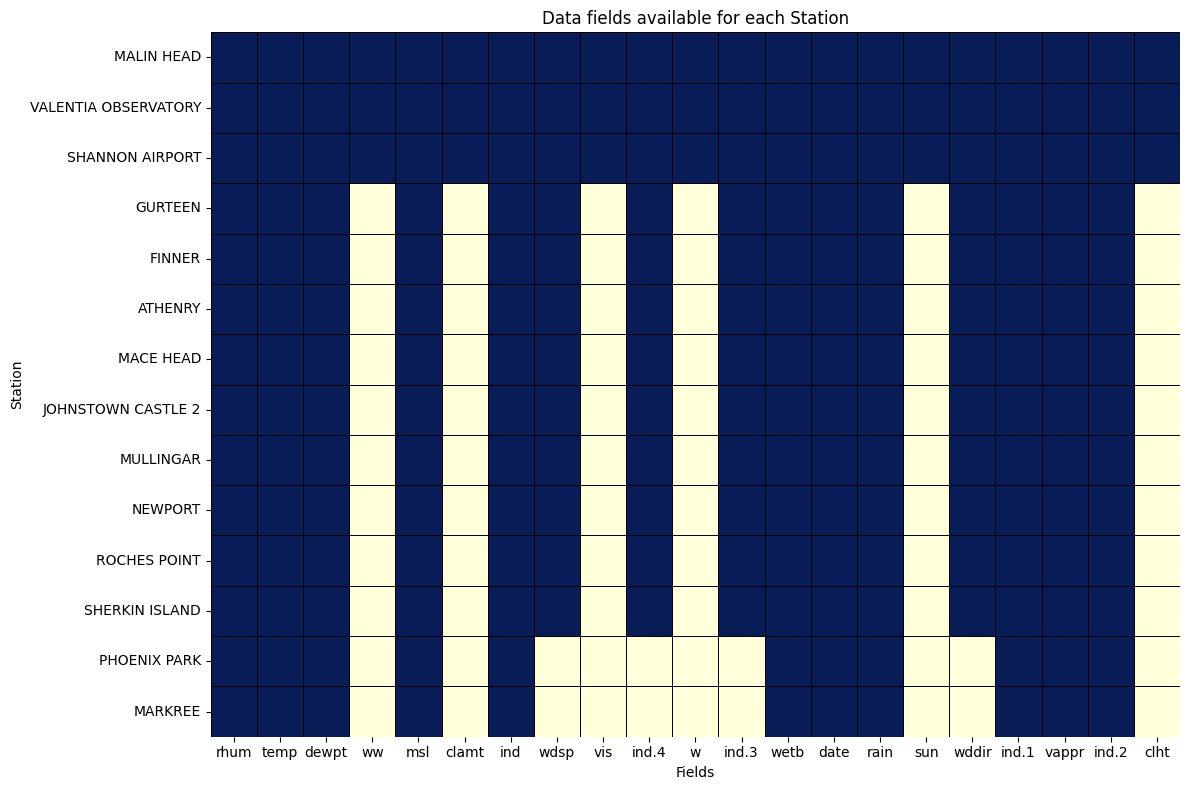

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(columns_present_df, cmap='YlGnBu', cbar=False, linewidths=0.5, linecolor='black')
plt.title('Data fields available for each Station')
plt.xlabel('Fields')
plt.ylabel('Station')
plt.tight_layout()
plt.show()